In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import stylia as st
from stylia import NamedColors, ContinuousColorMap, ONE_COLUMN_WIDTH, TWO_COLUMNS_WIDTH

DATAPATH = "../data"
RESULTSPATH = "../results"

colors = NamedColors()
red = colors.get("red")
blue = colors.get("blue")
purple = colors.get("purple")
yellow = colors.get("yellow")
green = colors.get("green")
orange = colors.get("orange")
gray = colors.get("gray")

## Predicted vs Known significant gene-drug assoc.

Number of significant genes per drug in our dataset of 32 drugs and number of siginificant drugs per ADME gene.

In [35]:
drugs = pd.read_csv(os.path.join("data", "curated_drugs.csv"))
d2g = pd.read_csv(os.path.join(RESULTSPATH, "results_pairs","chemical_gene_pairs_prediction_output_focus_with_variant_aggregates_zscore95_filter.csv" ))
print(len(list(set(d2g["gene"]))), len(list(set(d2g["chemical"]))))

# chemical names must be renamed to convention
chemok = {"rifampicin":"rifampin", "p-aminosalicylic acid":"aminosalicylic acid", "strepomycin":"streptomycin","linezolide":"linezolid"}
d2g['chemical'] = d2g['chemical'].str.lower()
d2g["chemical"] = d2g["chemical"].replace(chemok)
print(len(list(set(d2g["chemical"]))))

zscore_lim = 1.96
d2g_z95 = d2g[d2g["consensus_zscore"]>=zscore_lim]
print(len(list(set(d2g_z95["gene"]))), len(list(set(d2g_z95["chemical"]))))
d2g_z95.shape

genes_z95_counts = d2g_z95["chemical"].value_counts().reset_index().sort_values(by="count")
chemicals_z95_counts = d2g_z95["gene"].value_counts().reset_index().sort_values(by="count")

142 32
32
62 32


/var/folders/rx/fqf_ssrj14q0h5dmx8vgdvpm0000gn/T/ipykernel_6379/901305401.py:1: DtypeWarning: Columns (8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join("data", "pharmgkb_merged.csv"))


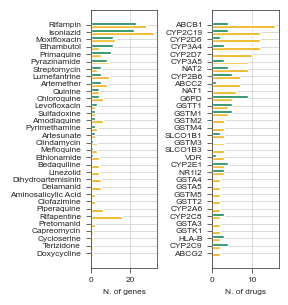

In [42]:
df = pd.read_csv(os.path.join("data", "pharmgkb_merged.csv"))
drugs = pd.read_csv(os.path.join("data", "curated_drugs.csv"))
drugs_notann = list(set(drugs["chemical"])-set(df["chemical"]))
sel_df = df[df["chemical"].isin(drugs["chemical"])]
sel_df = sel_df[["chemical", "gene"]]
sel_df = sel_df.drop_duplicates(keep="first")

genes_pgkb_counts = sel_df["chemical"].value_counts().reset_index()
genes_pgkb_counts = pd.concat([genes_pgkb_counts,pd.DataFrame({'chemical': list(drugs_notann), 'count': 0})], ignore_index=True)
genes_pgkb_counts.sort_values("count", inplace=True)
genes_pgkb_counts.rename(columns={"count":"count_pgkb"}, inplace=True)
genes_z95_counts.rename(columns={"count":"count_pred"}, inplace=True)
gene_counts = genes_z95_counts.merge(genes_pgkb_counts, on="chemical", how="left")
gene_counts['count_pgkb'] = gene_counts['count_pgkb'].fillna(0).astype(int)
gene_counts.sort_values(by="count_pgkb", inplace=True)

chemicals_pgkb_counts = sel_df["gene"].value_counts().reset_index()
chemicals_pgkb_counts.sort_values("count", inplace=True)
chemicals_pgkb_counts.rename(columns={"count":"count_pgkb"}, inplace=True)
chemicals_z95_counts.rename(columns={"count":"count_pred"}, inplace=True)
chemicals_counts = chemicals_z95_counts.merge(chemicals_pgkb_counts, on="gene", how="left")
chemicals_counts['count_pgkb'] = chemicals_counts['count_pgkb'].fillna(0).astype(int)
chemicals_counts.sort_values(by="count_pred", inplace=True)

fig, axs = st.create_figure(1,2, width=TWO_COLUMNS_WIDTH*0.4, height=3)
bar_width = 0.4

ax = axs.next()
index = range(len(gene_counts))
bar1 = ax.barh([i - bar_width/2 for i in index], gene_counts['count_pred'], bar_width, label='Predicted', color=yellow)
bar2 = ax.barh([i + bar_width/2 for i in index], gene_counts['count_pgkb'], bar_width, label='PharmGKB', color=green )
ax.set_yticks(index)
ax.set_yticklabels(gene_counts['chemical'].str.title())
st.label(ax, ylabel="", xlabel="N. of genes", title="", abc="")

ax = axs.next()
index = range(len(chemicals_counts.tail(32)))
bar1 = ax.barh([i - bar_width/2 for i in index], chemicals_counts['count_pred'].tail(32), bar_width, label='Predicted', color=yellow)
bar2 = ax.barh([i + bar_width/2 for i in index], chemicals_counts['count_pgkb'].tail(32), bar_width, label='PharmGKB', color=green )
ax.set_yticks(index)
ax.set_yticklabels(chemicals_counts['gene'].tail(32))
st.label(ax, ylabel="", xlabel="N. of drugs", title="")
plt.tight_layout()
st.save_figure("assets/pred_vs_pgkb_genesdrugs.png")
st.save_figure("assets/pred_vs_pgkb_genesdrugs.pdf")

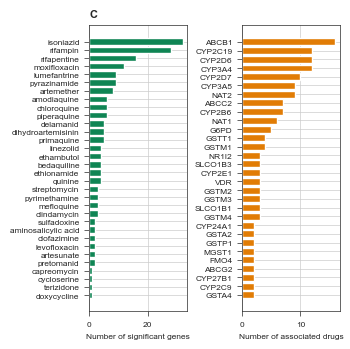

In [40]:
fig, axs = st.create_figure(1,2, width=ONE_COLUMN_WIDTH, height=ONE_COLUMN_WIDTH)
ax = axs.next()
ax.barh(genes_z95_counts["chemical"], genes_z95_counts["count_pred"], color=green)
st.label(ax, ylabel="", xlabel="Number of significant genes", title="", abc= "C")
ax = axs.next()
ax.barh(chemicals_z95_counts["gene"].tail(30), chemicals_z95_counts["count_pred"].tail(30), color=orange)
st.label(ax, ylabel="", xlabel="Number of associated drugs", title="", abc= "")
plt.tight_layout()

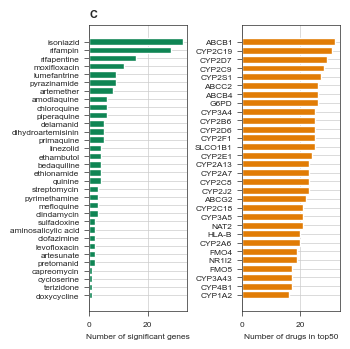

In [41]:
t50 = pd.read_csv(os.path.join(RESULTSPATH, "results_pairs","chemical_gene_pairs_prediction_output_focus_with_variant_aggregates_top50_filter.csv"))
t50_chemicals = t50["gene"].value_counts().reset_index().sort_values(by="count")
fig, axs = st.create_figure(1,2, width=ONE_COLUMN_WIDTH, height=ONE_COLUMN_WIDTH)
ax = axs.next()
ax.barh(genes_z95_counts["chemical"], genes_z95_counts["count_pred"], color=green)
st.label(ax, ylabel="", xlabel="Number of significant genes", title="", abc= "C")
ax = axs.next()
ax.barh(t50_chemicals["gene"].tail(30), t50_chemicals["count"].tail(30), color=orange)
st.label(ax, ylabel="", xlabel="Number of drugs in top50", title="", abc= "")
plt.tight_layout()